**Authentication**

In [2]:
from google.colab import auth
auth.authenticate_user()

**Intializing BigQuery Client**

In [3]:
from google.cloud import bigquery

project_id = 'icoads-time-series-analysis'
client = bigquery.Client(project=project_id)

**Importing Libraries**

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch import nn
import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

**Loading the data**

In [5]:
sql = f"""
SELECT
  year,
  month,
  day,
  hour,
  latitude,
  longitude,
  indicator_for_temp,
  sea_surface_temp,
  sst_measurement_method,
  sea_level_pressure,
  wind_direction_indicator,
  wind_direction_true,
  wind_speed_indicator,
  wind_speed
FROM `icoads-time-series-analysis.icoads_data.torpedo_wharf_data`
WHERE sea_surface_temp IS NOT NULL
"""


df = client.query(sql).to_dataframe()
print('rows:', len(df))
df.head()

rows: 355906


,year,month,day,hour,latitude,longitude,indicator_for_temp,sea_surface_temp,sst_measurement_method,sea_level_pressure,wind_direction_indicator,wind_direction_true,wind_speed_indicator,wind_speed
0,2007,10,19,0.0,37.81,-122.47,0,14.1,1,1020.0,0,290,4,2.1
1,2009,6,16,0.0,37.81,-122.47,0,15.0,1,1014.7,0,250,4,6.2
2,2014,2,6,0.0,37.81,-122.47,0,11.7,1,1020.4,0,260,4,4.6
3,2006,8,4,0.0,37.81,-122.47,0,16.7,1,1010.4,0,240,4,7.2
4,2013,2,9,0.0,37.81,-122.47,0,10.6,1,1015.1,0,260,4,4.1


**Creating Cyclical Time Features for Time Series Modeling**

In [7]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.sort_values('datetime').reset_index(drop=True)

# Cyclical time features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

**Selecting Features and Target for Model Training**

In [22]:
target_col = 'sea_surface_temp'

feature_cols = [
    'latitude', 'longitude',
    'sea_level_pressure',
    'wind_speed',
    'month_sin', 'month_cos', 'hour_sin', 'hour_cos'
]

X = df[feature_cols].values
y = df[target_col].values.reshape(-1, 1)

**Handling Missing Values and Ensuring Numeric Data Types**

In [23]:
df = df.replace({pd.NA: np.nan})
df = df.fillna(method="ffill").fillna(method="bfill")

for c in feature_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df[feature_cols] = df[feature_cols].fillna(0)
X = df[feature_cols].values.astype(float)
y = df[target_col].values.reshape(-1, 1).astype(float)

/tmp/ipython-input-3613607188.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")   # fallback


**Scaling Features and Target Using StandardScaler**

In [24]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

**Preparing Sliding Window Sequences for LSTM Training**

In [25]:
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len=48):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        X_seq = self.X[idx:idx + self.seq_len]
        y_target = self.y[idx + self.seq_len]
        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_target, dtype=torch.float32)


**Train, Validation, and Test Sets with Sequence DataLoaders**

In [26]:
SEQ_LEN = 48

split1 = int(0.7 * len(X_scaled))
split2 = int(0.9 * len(X_scaled))

train_ds = SequenceDataset(X_scaled[:split1], y_scaled[:split1], SEQ_LEN)
val_ds = SequenceDataset(X_scaled[split1:split2], y_scaled[split1:split2], SEQ_LEN)
test_ds = SequenceDataset(X_scaled[split2:], y_scaled[split2:], SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

**Defining the LSTM Model Architecture**

In [27]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

**Initializing LSTM Model, Loss Function, and Optimizer**

In [40]:
model = LSTMModel(input_dim=X.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Training Loop for LSTM Model with Validation**

In [29]:
EPOCHS = 10

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    batch_losses = []
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    # validation
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            val_batch_losses.append(loss.item())

    val_loss = np.mean(val_batch_losses)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1/10 | Train Loss: 0.1669 | Val Loss: 0.9971
Epoch 2/10 | Train Loss: 0.1349 | Val Loss: 0.9550
Epoch 3/10 | Train Loss: 0.1256 | Val Loss: 0.9886
Epoch 4/10 | Train Loss: 0.1187 | Val Loss: 1.0602
Epoch 5/10 | Train Loss: 0.1110 | Val Loss: 1.0011
Epoch 6/10 | Train Loss: 0.1039 | Val Loss: 1.0053
Epoch 7/10 | Train Loss: 0.0961 | Val Loss: 0.9939
Epoch 8/10 | Train Loss: 0.0893 | Val Loss: 0.9831
Epoch 9/10 | Train Loss: 0.0824 | Val Loss: 1.0463
Epoch 10/10 | Train Loss: 0.0758 | Val Loss: 1.0452


**Visualizing Training and Validation Loss**

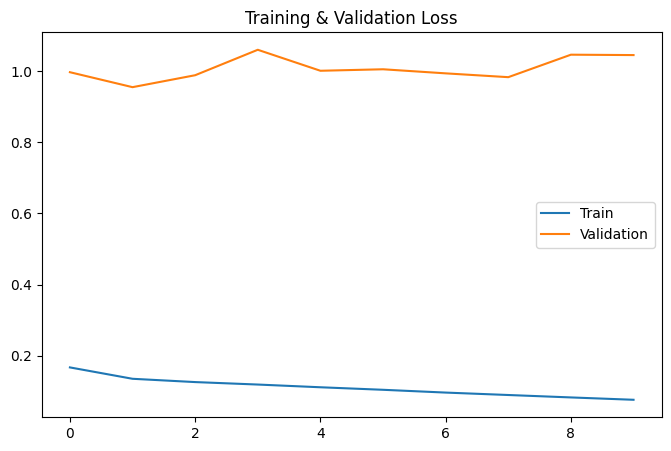

In [30]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

**Generating Predictions on Test Set and Inverse Scaling**

In [31]:
model.eval()
preds_scaled = []
actual_scaled = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        pred = model(X_batch)
        preds_scaled.extend(pred.numpy())
        actual_scaled.extend(y_batch.numpy())

preds = scaler_y.inverse_transform(preds_scaled)
actual = scaler_y.inverse_transform(actual_scaled)

**Error Calculation**

In [43]:
mse = mean_squared_error(actual, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, preds)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)

MSE: 4.190147769014786
RMSE: 2.0469850436714934
MAE: 1.712695565619476


**Plotting Actual vs Predicted Sea Surface Temperature**

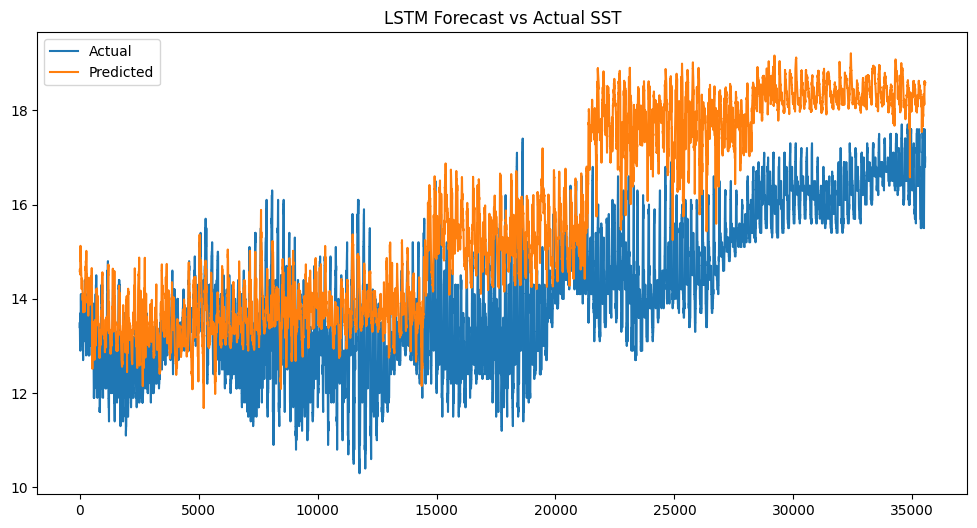

In [33]:
plt.figure(figsize=(12,6))
plt.plot(actual, label='Actual')
plt.plot(preds, label='Predicted')
plt.legend()
plt.title("LSTM Forecast vs Actual SST")
plt.show()